In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [3]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [4]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [5]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').astype(float)

## 2. Add Features

In [6]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df["auc_year_month"]=df["start_date"].map(lambda x: x.strftime('%Y-%m'))
df["auc_year_month_date"]=df["start_date"].map(lambda x: x.strftime('%Y-%m-%d'))

In [23]:
df['auc_season_num'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)
def season(x):
    if x==1:
        return "winter"
    elif x==2:
        return "spring"
    elif x==3:
        return "summer"
    else: return "fall"
df["auc_season"] = df["auc_season_num"].apply(season)

In [8]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)

In [9]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [10]:
# returns nth_in_auction divided by lot_number = percentage through the auction the lot when lot was shown
lot_order_df = df[['nth_in_auction', 'number_of_lots']].copy()
df['percent_in_auction'] = np.round(lot_order_df.nth_in_auction / lot_order_df.number_of_lots, 3)*100

In [11]:
# Add avg_estimate
df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

In [12]:
# Add author era
import re

df["auth_era_num"]= df["birth_year"]//10
def tostr(x):
    temp=str(x)
    temp=temp[:3]+"0"
    return temp
df["auth_era"]=df["auth_era_num"].apply(tostr)

## 3. Convert Currency

In [13]:
df = df[df["currency"].isnull()==False]

In [14]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = hammer_price.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_low_usd'] = est_low.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)    
df['estimate_high_usd'] = est_high.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_avg_usd'] = est_avg.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)

## 4. Add more features based on the converted price

In [15]:
# Add converted Hammer Price Range
def price_range(x):
    if x <10000:
        return "<$10,000"
    elif x<50000:
        return "<$50,000"
    elif x <500000:
        return "<$500,000"
    elif x is None:
        return None
    else: return "$500,000+"
df["hammer_price_bp_usd_range"] = df["hammer_price_bp_usd"].apply(price_range)

## 4. Export to CSV

In [16]:
df.to_csv("final_sothebys.csv")

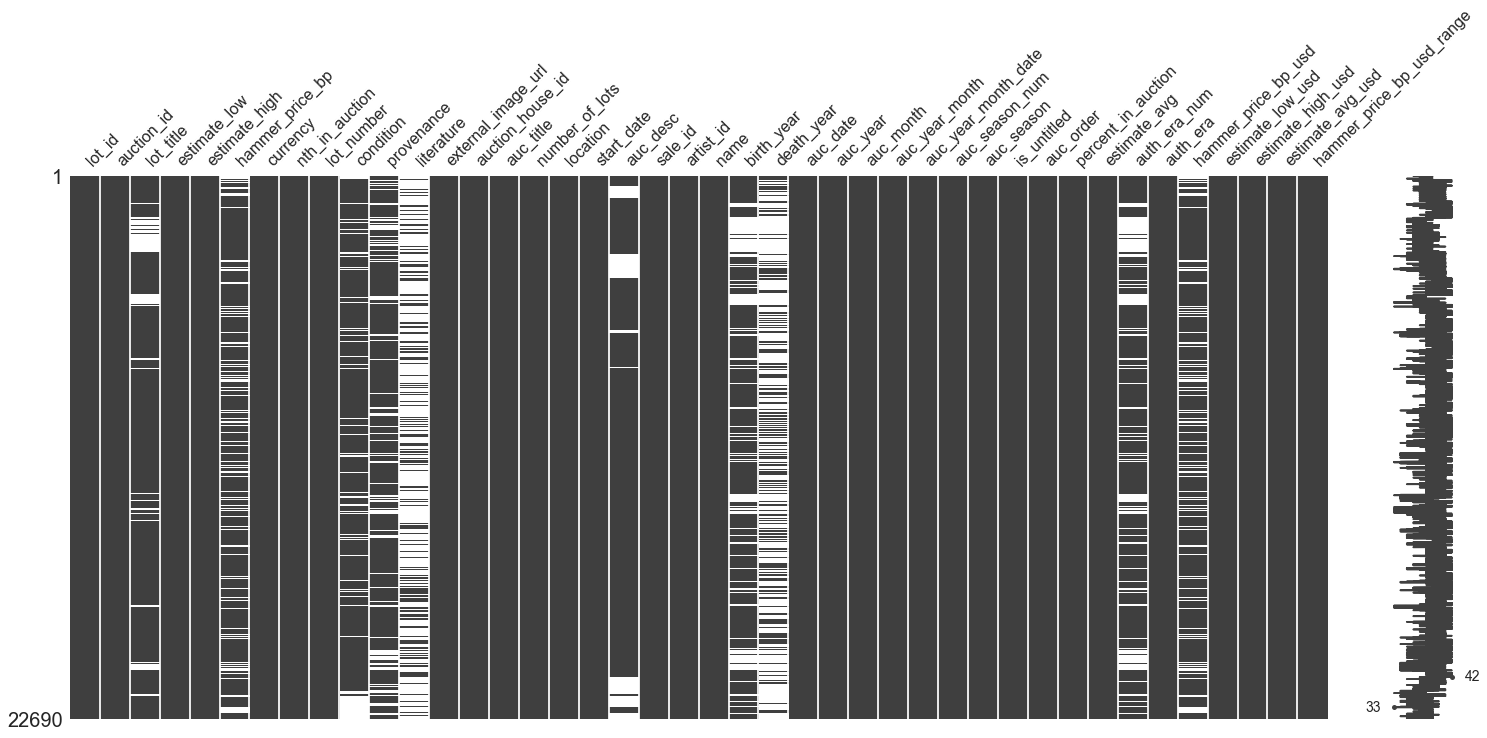

In [17]:
msno.matrix(df)

In [19]:
#check 
#change the 100% thing
#paracord- interactive
temp1=df.groupby("auction_id").size().reset_index(name='counts')
temp2=df.groupby("auction_id")['number_of_lots'].mean().reset_index(name='counts')
tempall=temp1.merge(temp2,on="auction_id")

In [20]:
tempall["diff"]=tempall["counts_x"]-tempall["counts_y"]

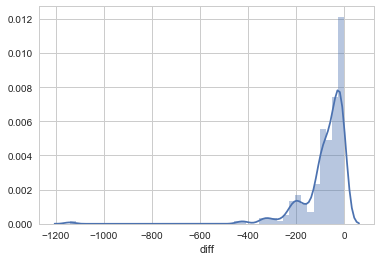

In [21]:
sns.distplot(tempall["diff"])

In [29]:
df["new_check"]=np.where(df["lot_title"].str.contains('OPARD'),1,0)


In [28]:
df.sort_values(by="hammer_price_bp_usd",ascending=False).iloc[:30]

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_year_month,auc_year_month_date,auc_season_num,auc_season,is_untitled,auc_order,percent_in_auction,estimate_avg,auth_era_num,auth_era,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd,hammer_price_bp_usd_range,new_check
19450,2090,23,UNTITLED (YELLOW AND BLUE),40000000.0,60000000.0,46450000.0,USD,11,11,Please contact the Contemporary Art Department...,Estate of the Artist (Estate no. 5157.54)<br>M...,“These are the edgings and inchings of final f...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Evening Auction,63,NEW YORK,2015-05-12 23:00:00.253,Results\nSotheby's New York Contemporary Art t...,N09345,974,Mark Rothko,1903.0,1970,2015-05-12,2015,5,2015-05,2015-05-12,2,spring,1,2,17.5,50000000.0,190.0,1900,46450000.00,40000000.00,60000000.00,50000000.00,"$500,000+",0
18894,2420,37,ABSTRAKTES BILD,14000000.0,20000000.0,30389000.0,GBP,36,37,Colour:\nThe colour in the catalogue illustrat...,"Michael and Eleonore Stoffel Foundation, Colog...",“Richter’s painting explores the enigmatic jun...,http://www.sothebys.com/content/dam/stb/lots/L...,1,Contemporary Art Evening Auction,74,LONDON,2015-02-10 18:30:00.845,"RESULTS\n\nOur evening auction realised £123,5...",L15020,133,Gerhard Richter,1932.0,NaN,2015-02-10,2015,2,2015-02,2015-02-10,1,winter,0,5,48.6,17000000.0,193.0,1930,46267457.28,21315094.34,30450134.77,25882614.56,"$500,000+",0
7153,12874,145,THREE STUDIES FOR PORTRAIT OF GEORGE DYER (ON ...,15000000.0,20000000.0,26682500.0,GBP,15,15,Colour:The colours in the catalogue illustrati...,This work will be included as number&nbsp;<em>...,"""A compact and chunky force of nature, with a ...",http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Evening Auction,57,LONDON,2014-06-30 18:00:00.800,RESULTS\n\nThe Best of British drove Sotheby’s...,L14022,1208,Francis Bacon,1909.0,1992,2014-06-30,2014,6,2014-06,2014-06-30,3,summer,0,4,26.3,17500000.0,190.0,1900,45468444.79,25560823.46,34081097.94,29820960.70,"$500,000+",0
6716,13349,169,ONEMENT VI,30000000.0,40000000.0,43845000.0,USD,17,17,This painting is in excellent condition overal...,"Collection Annalee Newman (gift of the artist,...",Onement VI by Barnett Newman overwhelms and se...,http://www.sothebys.com/content/dam/stb/lots/N...,1,Contemporary Art Evening Auction,64,NEW YORK,2013-05-14 23:00:00.354,OVERVIEW\n\nSotheby’s Contemporary Art Evening...,N08991,1660,Barnett Newman,1905.0,1970,2013-05-14,2013,5,2013-05,2013-05-14,2,spring,0,4,26.6,35000000.0,190.0,1900,43845000.00,30000000.00,40000000.00,35000000.00,"$500,000+",0
4032,21082,213,200 ONE DOLLAR BILLS,8000000.0,12000000.0,43762500.0,USD,21,22,This painting is in excellent condition. Pleas...,"Green Gallery, New York<br>Robert C. and Ethel...",200 One Dollar Bills is the monumental masterp...,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Evening Auction,52,NEW YORK,2009-11-12 00:00:00.000,NaN,N08592,79,Andy Warhol,1928.0,1987,2009-11-12,2009,11,2009-11,2009-11-12,4,fall,0,3,40.4,10000000.0,192.0,1920,43762500.00,8000000.00,12000000.00,10000000.00,"$500,000+",0
8378,13518,182,"NUMBER 4, 1951",25000000.0,35000000.0,40402500.0,USD,10,10,This painting is in excellent condition. Pleas...,"Betty Parsons Gallery, New York<br>Dr. Ruth Fo...","""I approach painting in the same sense as one ...",http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Evening Auction,68,NEW YORK,2012-11-14 00:00:00.628,"OVERVIEW\n\nA seminal, large-scale masterpiece...",N08900,964,Jackson Pollock,1912.0,1956,2012-11-14,2012,11,2012-11,2012-11-14,4,fall,0,1,14.7,30000000.0,191.0,1910,40402500.00,25000000.00,35000000.00,30000000.00,"$500,000+",0
11206,12755,139,UN

In [22]:
df[df["auc_year"]<2010]["auc_year_month_date"]

448      2009-07-01
449      2009-07-01
450      2009-07-01
451      2009-07-01
452      2009-07-01
453      2009-07-01
454      2009-07-01
455      2009-07-01
456      2009-07-01
457      2009-07-01
458      2009-07-01
459      2009-07-01
460      2009-07-01
461      2009-07-01
462      2009-07-01
463      2009-07-01
464      2009-07-01
465      2009-07-01
466      2009-07-01
467      2009-07-01
468      2009-07-01
469      2009-07-01
470      2009-07-01
471      2009-07-01
472      2009-07-01
473      2009-07-01
474      2009-07-01
475      2009-07-01
476      2009-07-01
477      2009-07-01
478      2009-07-01
479      2009-07-01
480      2009-07-01
481      2009-07-01
482      2009-07-01
483      2009-07-01
484      2009-07-01
485      2009-07-01
486      2009-07-01
487      2009-07-01
488      2009-07-01
489      2009-07-01
490      2009-07-01
491      2009-07-01
492      2009-07-01
493      2009-07-01
494      2009-07-01
495      2009-07-01
496      2009-07-01
497      2009-07-01
